In [23]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
immigration_data_2012_2021 = "Resources/immigration_data_2005_2021.csv"
#state_unemployment = "Resources/emp-unemployment.xls"
#gini = "Resources/gini_index_by_state_2016_2018.xlsx"

In [3]:
inmigration = pd.read_csv(immigration_data_2012_2021)
inmigration.head()

,Year,Region and country of birth,Total Permanent Residents,Percentage,Alabama,Alaska,Arizona,Arkansas,California,Colorado,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
0,2005,Total,1122373,100.00,4200,1525,18988,2698,232023,11977,...,27100,26482,847,7909,321,128,5868,0,0,0
1,2005,"China, People's Republic",69967,6.23,328,92,543,202,17668,765,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,2.45,5,42,22,0,82,6,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,7.54,431,15,739,215,14724,516,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,1.24,48,4,285,9,7059,131,...,562,318,18,48,0,0,0,0,0,0


## Cleaning country regressor dataset

In [4]:
#Read the csv
countries_raw_metadata = pd.read_csv("Resources/countries_metadata.csv", encoding='latin-1')
display(countries_raw_metadata.head())
print(countries_raw_metadata.shape)

,Country Name,Country Code,Series Name,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


(70, 67)


In [5]:
#Delete the "[YR..]" in the year columns
for column in countries_raw_metadata.columns:
    if "[YR" in column:
        new_column_name = column.split("[")[0].strip() # Extract the part before '[YR' and remove any leading/trailing spaces
        countries_raw_metadata.rename(columns={column: new_column_name}, inplace=True)
countries_raw_metadata.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [6]:
#Clean the "Country Names" columns 
unique_names = countries_raw_metadata["Country Name"].unique()
unique_names

array(['China', 'United States', 'Iran, Islamic Rep.', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines', nan,
       'Data from database: World Development Indicators',
       'Last Updated: 06/29/2023', 'Code', 'SP.POP.TOTL',
       'NY.GDP.PCAP.CD', 'SL.UEM.TOTL.NE.ZS',
       'Unemployment is a key measure to monitor whether a country is on track to achieve the Sustainable Development Goal of promoting sustained',
       'However', 'SP.URB.TOTL.IN.ZS',
       "Percentages urban are the numbers of persons residing in an area defined as ''urban'' per 100 total population. They are calculated by the Statistics Division of the United Nations Department of Economic and Social Affairs. Particular caution should be used in interpreting the figures for percentage urban for different countries.",
       'Countries differ in the way they classify population as "urban" or "rural." The population of a city or metropolitan area depends on the bou

In [7]:
#List the country names we want to keep.
attributes_to_keep = ['China', 'United States', 'Iran, Islamic Rep.', 'India', 'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan', 'Philippines']

# Filter the DataFrame to keep only the desired attributes
df_filtered = countries_raw_metadata[countries_raw_metadata['Country Name'].isin(attributes_to_keep)]

# Print the filtered DataFrame
df_filtered.head()

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,"Population, total",SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban population (% of total population),SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [8]:
#Prepare the "Series Name" to move it to the columns, these will be our regressors. 
series_names = df_filtered["Series Name"].unique()
series_names

array(['Population, total', 'GDP per capita (current US$)',
       'Unemployment, total (% of total labor force) (national estimate)',
       'Urban population (% of total population)',
       'Birth rate, crude (per 1,000 people)', 'Gini index'], dtype=object)

In [9]:
df_filtered.loc[df_filtered["Series Name"] == 'Population, total', "Series Name"] = "Population_total"
df_filtered.loc[df_filtered["Series Name"] == 'GDP per capita (current US$)', "Series Name"] = "GDP_per_capita"
df_filtered.loc[df_filtered["Series Name"] == 'Unemployment, total (% of total labor force) (national estimate)', "Series Name"] = "UR"
df_filtered.loc[df_filtered["Series Name"] == 'Urban population (% of total population)', "Series Name"] = "Urban_population"
df_filtered.loc[df_filtered["Series Name"] == 'Birth rate, crude (per 1,000 people)', "Series Name"] = "Birth_rate_crude"
df_filtered.loc[df_filtered["Series Name"] == 'Gini index', "Series Name"] = "Gini_index"
df_filtered.loc[df_filtered["Country Name"] == 'Iran, Islamic Rep.', "Country Name"] = "Iran"
df_filtered

,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,CHN,Population_total,SP.POP.TOTL,667070000,660330000,665770000,682335000,698355000,715185000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,CHN,GDP_per_capita,NY.GDP.PCAP.CD,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,CHN,UR,SL.UEM.TOTL.NE.ZS,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,CHN,Urban_population,SP.URB.TOTL.IN.ZS,16.203,16.708,17.226,17.757,18.299,18.086,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,CHN,Birth_rate_crude,SP.DYN.CBRT.IN,20.86,18.02,37.01,43.37,39.14,37.88,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..
5,China,CHN,Gini_index,SI.POV.GINI,..,..,..,..,..,..,...,39.7,39.2,38.6,38.5,39.1,3.850000e+01,38.2,..,..,..
6,United States,USA,Population_total,SP.POP.TOTL,180671000,183691000,186538000,189242000,191889000,194303000,...,316059947,318386329,320738994,323071755,325122128,3.268382e+08,328329953,331511512,332031554,333287557
7,United States,USA,GDP_per_capita,NY.GDP.PCAP.CD,3007.12344537862,3066.56286916615,3243.84307754988,3374.51517105082,3573.94118474743,3827.52710972039,...,53291.1276891406,55123.8497869046,56762.7294515989,57866.7449341091,59907.754260885,6.282331e+04,65120.3946628653,63528.6343027508,70219.472454115,76398.5917422054
8,United States,USA,UR,SL.UEM.TOTL.NE.ZS,5.5,6.7,5.5,5.7,5.2,4.5,...,7.37,6.17,5.28,4.87,4.36,3.900000e+00,3.67,8.05,5.35,3.65
9,United States,USA,Urban_population,SP.URB.TOTL.IN.ZS,69.996,70.377,70.757,71.134,71.508,71.879,...,81.299,81.483,81.671,81.862,82.058,8.225600e+01,82.459,82.664,82.873,83.084


In [10]:
# Get rid the unnecessary columns
countries_regressors_raw = df_filtered.drop(columns= {"Country Code", "Series Code"} )
countries_regressors_raw.head()

,Country Name,Series Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,China,Population_total,667070000,660330000,665770000,682335000,698355000,715185000,735400000,754550000,...,1363240000,1371860000,1379860000,1387790000,1396215000,1.402760e+09,1407745000,1411100000,1412360000,1412175000
1,China,GDP_per_capita,89.5202179159242,75.8055639067957,70.9091553472599,74.3133748233246,85.4982461036748,98.4864217470782,104.324189073855,96.58918279471,...,7020.38568208449,7636.07422276004,8016.44601585644,8094.39037512163,8817.04549566316,9.905406e+03,10143.8602060373,10408.7191247747,12617.5049863004,12720.2156397612
2,China,UR,..,..,..,..,..,..,..,..,...,4.05,4.1,..,..,3.9,4.930000e+00,5.15,5.61,5.11,..
3,China,Urban_population,16.203,16.708,17.226,17.757,18.299,18.086,17.915,17.785,...,53.013,54.259,55.5,56.736,57.96,5.915200e+01,60.308,61.428,62.512,63.56
4,China,Birth_rate_crude,20.86,18.02,37.01,43.37,39.14,37.88,35.05,33.96,...,13.03,13.83,11.99,13.57,12.64,1.086000e+01,10.41,8.52,7.52,..


In [11]:
#countries_regressors_raw.info()

## Cleaning inmigration csv

In [12]:
migration = inmigration.rename(columns={"Region and country of birth": "Country_origin", "Total Permanent Residents": "Total_inmigrants"})
migration = migration[migration["Country_origin"]!= "Total"]
migration = migration.drop(columns="Percentage")
migration["Country_origin"] = migration["Country_origin"].replace("China, People's Republic", "China")
migration

,Year,Country_origin,Total_inmigrants,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,...,Virginia,Washington,West Virginia,Wisconsin,Wyoming,U.S. Armed Services posts,U.S. possessions,U.S. Dependencies,Guam,Puerto Rico
1,2005,China,69967,328,92,543,202,17668,765,894,...,1327,1508,101,593,28,13,184,0,0,0
2,2005,Dominican Republic,27504,5,42,22,0,82,6,319,...,90,18,6,39,0,0,2346,0,0,0
3,2005,India,84681,431,15,739,215,14724,516,1571,...,2776,1747,133,876,0,0,24,0,0,0
4,2005,Iran,13887,48,4,285,9,7059,131,88,...,562,318,18,48,0,0,0,0,0,0
5,2005,Mexico,161445,569,96,8373,870,63092,2891,316,...,870,2330,30,1054,75,0,129,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2021,Iran,5734,21,0,86,17,2206,89,39,...,218,187,9,38,0,0,0,0,0,0
149,2021,Mexico,107230,323,33,6859,610,31715,3131,247,...,586,2539,20,949,69,0,0,0,0,39
150,2021,Pakistan,9691,31,0,59,41,1104,52,111,...,784,166,17,57,3,0,0,0,0,0
151,2021,Philippines,27511,152,190,555,129,6478,228,178,...,648,737,69,236,27,0,0,0,300,9


In [29]:
country_names=['China', 'India',
       'Dominican Republic', 'Mexico', 'United Kingdom', 'Pakistan',
       'Philippines']




state_names=['Alabama', 'Alaska',
       'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
       'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming']

df_predictions = pd.DataFrame(columns=['Year', 'Country', 'State', 'Predicted Immigration', 'R2'])
all_preds = []
all_true = []
variables_by_state_raw = pd.read_csv("Resources/variable 2011-2021.csv")
variables_by_state_rename = variables_by_state_raw.rename(columns={"Unemployeement Rate": "UR_STATE",
                                                                   "GDP Per Capita":"GDP_per_capita_state", "Birth Rate":"Bith_rate_state"  })
# Multiply the "unemployment rate" column by 10
variables_by_state_rename["UR_STATE"] *= 10



results_df = pd.DataFrame(columns=['Country', 'State', 'MAE', 'MAPE','pred2023'])


for country in country_names:
    
    # Filter by country
    regressor_by_country = countries_regressors_raw.loc[countries_regressors_raw["Country Name"]== country]
    # Drop the Country Name column
    drop_countryname = regressor_by_country.drop(columns="Country Name")
    # Transpose rows per columns
    regressor_by_country_not_cleaned = drop_countryname.transpose()
    # Use the first row as the column names
    regressor_by_country_not_cleaned.columns = regressor_by_country_not_cleaned.iloc[0]
    # Drop the first row (previous integer index) since it's now redundant
    regressor_by_country_drop_row = regressor_by_country_not_cleaned.iloc[1:]
    print(country)
    regressor_by_country_reset_index = regressor_by_country_drop_row.reset_index().rename(columns={"index":"Year"})
    regressor_by_country_reset_index["Year"] = regressor_by_country_reset_index["Year"].astype(int)
    regressor_by_country_reset_index["Population_total"] = regressor_by_country_reset_index["Population_total"].astype(int)
    regressor_by_country_reset_index["GDP_per_capita"] = regressor_by_country_reset_index["GDP_per_capita"].astype(float)
    regressor_by_country_reset_index['UR'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["UR"] = regressor_by_country_reset_index["UR"].astype(float)
    regressor_by_country_reset_index["Urban_population"] = regressor_by_country_reset_index["Urban_population"].astype(float)
    regressor_by_country_reset_index['Birth_rate_crude'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Birth_rate_crude"] = regressor_by_country_reset_index["Birth_rate_crude"].astype(float)
    regressor_by_country_reset_index['Gini_index'].replace('..', np.nan, inplace=True)
    regressor_by_country_reset_index["Gini_index"] = regressor_by_country_reset_index["Gini_index"].astype(float)
    regressor_by_country_reset_index['Covid'] = regressor_by_country_reset_index['Year'].apply(lambda x: 1 if x in [2020, 2021] else 0)
    regressor_by_country = regressor_by_country_reset_index
    display(regressor_by_country)
    
    
    for state in state_names:



        # Getting the DataFrame with the years, total number of inmigrants in the US for a given country and 
        # the number of inmigrants of this country in one US state
        county_origin_us_df = migration[migration["Country_origin"]==country]
        country_columns = ["Year","Total_inmigrants",state]
        inmigration_us_df = county_origin_us_df[country_columns]

        #Filter by state
        state_test = variables_by_state_rename[variables_by_state_rename["State"]==state]
        regressor_by_state = state_test.drop(columns= "State").reset_index(drop=True)
    
        # First merge inmigration_us_df and regressor_by_country
        df_merged1 = pd.merge(inmigration_us_df, regressor_by_country, on="Year", how="left")

        # Then merge the result with regressor_by_state
        df_merged = pd.merge(df_merged1, regressor_by_state, on="Year", how="left")

        
        # LINEAR REGRESSION TRAINING
        
        # Handle NaN values in the DataFrame
        # For simplicity, we'll fill the NaN values with the column means
        df_merged.fillna(df_merged.mean(), inplace=True)
    
    
        
        # Step 1: Prepare the DataFrame with time series data and regressors
        X = df_merged[['Year','Population_total', 'GDP_per_capita', 'UR', 
                       'Urban_population', 'Birth_rate_crude', 'Gini_index', 'GDP', 
                       'GDP_per_capita_state', "Covid"]].copy()
        y = df_merged[state].values # Target for the specific state

        # Step 2: Handle missing values in the DataFrame
        imputer = SimpleImputer(strategy='mean')
        X[['Population_total', 
           'GDP_per_capita', 'UR', 
           'Urban_population', 'Gini_index', 
           'GDP', 'GDP_per_capita_state']] = imputer.fit_transform(X[['Population_total', 'GDP_per_capita', 'UR', 'Urban_population', 'Gini_index', 'GDP',  'GDP_per_capita_state']])
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        # Create and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Calculate predicted values for the testing set
        y_pred_test = model.predict(X_test)

        # Append predicted and true values to the respective lists
        all_preds.extend(y_pred_test)
        all_true.extend(y_test)
        
        
        # Create a list of next 5 years
        next_5_years = pd.DataFrame({
            'Year': np.array(range(max(X['Year']) + 1, max(X['Year']) + 6)),
            'Population_total': [X['Population_total'].mean()] * 5,
            'GDP_per_capita': [X['GDP_per_capita'].mean()] * 5,
            'UR': [X['UR'].mean()] * 5,
            'Urban_population': [X['Urban_population'].mean()] * 5,
            'Birth_rate_crude': [X['Birth_rate_crude'].mean()] * 5,
            'Gini_index': [X['Gini_index'].mean()] * 5,
            'GDP': [X['GDP'].mean()] * 5,
            'GDP_per_capita_state': [X['GDP_per_capita_state'].mean()] * 5,
            'Covid': [1, 0, 0, 0, 0]
        })
        
        # Step 5: Calculate overall R2 score
        overall_r2 = r2_score(all_true, all_preds)
        
        # Predict the immigration for the next 5 years and store in the predictions DataFrame
        predictions = model.predict(next_5_years)
        df_predictions = df_predictions.append(pd.DataFrame({
            'Year': next_5_years['Year'].values,
            'Country': country,
            'State': state,
            'Predicted Immigration': predictions,
            'R2': overall_r2
        }), ignore_index=True)

        # Step 3: Convert predictions to positive values (assuming the target variable should be positive)
        predictions = np.maximum(predictions, 0)

        # Step 4: Display the predicted values for the next 5 years
        print("Predicted Immigration for the next 5 years for " + country + " " + state + ":")
        print(predictions)

        # Step 6: Display the MAE and MAPE for the testing set
        print("Overall R2 score " + country + " " + state + ": " + str(overall_r2))
       




China


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,667070000,89.520218,NaN,16.203,20.86,NaN,0
1,1961,660330000,75.805564,NaN,16.708,18.02,NaN,0
2,1962,665770000,70.909155,NaN,17.226,37.01,NaN,0
3,1963,682335000,74.313375,NaN,17.757,43.37,NaN,0
4,1964,698355000,85.498246,NaN,18.299,39.14,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,1402760000,9905.406118,4.93,59.152,10.86,38.5,0
59,2019,1407745000,10143.860206,5.15,60.308,10.41,38.2,0
60,2020,1411100000,10408.719125,5.61,61.428,8.52,NaN,1
61,2021,1412360000,12617.504986,5.11,62.512,7.52,NaN,1


Predicted Immigration for the next 5 years for China Alabama:
[296.44106842 351.71293172 361.38500595 371.05708019 380.72915443]
Overall R2 score China Alabama: 0.7365971853165687
Predicted Immigration for the next 5 years for China Alaska:
[371.43840989 416.6354304  452.48104901 488.32666761 524.17228622]
Overall R2 score China Alaska: 0.8940087551173842
Predicted Immigration for the next 5 years for China Arizona:
[10191.78607702 11239.3926446  12306.70247469 13374.01230478
 14441.32213488]
Overall R2 score China Arizona: 0.6279881880940588
Predicted Immigration for the next 5 years for China Arkansas:
[2258.66702873 2371.98576526 2596.36864146 2820.75151766 3045.13439386]
Overall R2 score China Arkansas: 0.6025800741172047
Predicted Immigration for the next 5 years for China California:
[526070.29032362 613480.80745815 672238.13096918 730995.45448022
 789752.77799125]
Overall R2 score China California: 0.7612312168308671
Predicted Immigration for the next 5 years for China Colorado:

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for China Hawaii:
[ 9258.84742126 10478.78858661 11455.1288119  12431.46903718
 13407.80926247]
Overall R2 score China Hawaii: 0.7805723094869077
Predicted Immigration for the next 5 years for China Idaho:
[4627.90450173 5165.74818133 5669.71433697 6173.68049261 6677.64664826]
Overall R2 score China Idaho: 0.7828022143864599
Predicted Immigration for the next 5 years for China Illinois:
[33437.52872747 38304.81408521 41881.05805264 45457.30202007
 49033.54598751]
Overall R2 score China Illinois: 0.770724230156553
Predicted Immigration for the next 5 years for China Indiana:
[2296.22071032 2381.0631744  2569.27269201 2757.48220961 2945.69172722]
Overall R2 score China Indiana: 0.771942596512786
Predicted Immigration for the next 5 years for China Iowa:
[0. 0. 0. 0. 0.]
Overall R2 score China Iowa: 0.7735974373178693
Predicted Immigration for the next 5 years for China Kansas:
[1573.99521733 1382.16684966 1498.54901251 1614.93117536 1731.3133382

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for China Mississippi:
[0. 0. 0. 0. 0.]
Overall R2 score China Mississippi: 0.7644092570037205
Predicted Immigration for the next 5 years for China Missouri:
[2583.39336437 2932.66101423 3179.83824554 3427.01547685 3674.19270815]
Overall R2 score China Missouri: 0.7649258771545614
Predicted Immigration for the next 5 years for China Montana:
[104.76743525  26.9909213   25.55116901  24.11141672  22.67166442]
Overall R2 score China Montana: 0.7659408769149785
Predicted Immigration for the next 5 years for China Nebraska:
[1958.95929705 2191.17172954 2398.30581048 2605.43989142 2812.57397236]
Overall R2 score China Nebraska: 0.7667657443032528
Predicted Immigration for the next 5 years for China Nevada:
[20406.81878004 23015.08291702 25242.47847103 27469.87402505
 29697.26957907]
Overall R2 score China Nevada: 0.766449513548351
Predicted Immigration for the next 5 years for China New Hampshire:
[0. 0. 0. 0. 0.]
Overall R2 score China New Hampshir

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for China Oklahoma:
[269.79410271 161.41581206 156.93855123 152.4612904  147.98402957]
Overall R2 score China Oklahoma: 0.4570329727706258
Predicted Immigration for the next 5 years for China Oregon:
[12088.15692397 12936.31040042 14164.69914391 15393.0878874
 16621.47663088]
Overall R2 score China Oregon: 0.45726421918413607
Predicted Immigration for the next 5 years for China Pennsylvania:
[36074.3815524  40069.37498923 43876.13332039 47682.89165155
 51489.64998271]
Overall R2 score China Pennsylvania: 0.4557287087930303
Predicted Immigration for the next 5 years for China Rhode Island:
[1776.2041042  2019.59231869 2208.9942163  2398.39611391 2587.79801152]
Overall R2 score China Rhode Island: 0.45723075397518476
Predicted Immigration for the next 5 years for China South Carolina:
[1066.49236603  427.32246895  448.83150897  470.34054899  491.849589  ]
Overall R2 score China South Carolina: 0.45828894753430716
Predicted Immigration for the ne

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,445954579,83.035102,NaN,17.924,42.506,NaN,0
1,1961,456351876,85.969704,NaN,18.032,42.294,NaN,0
2,1962,467024193,90.276869,NaN,18.218,42.101,NaN,0
3,1963,477933619,101.315165,NaN,18.405,41.907,NaN,0
4,1964,489059309,115.487608,NaN,18.595,41.721,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,1369003306,1974.377730,7.65,34.030,17.651,34.6,0
59,2019,1383112050,2050.163790,6.51,34.472,17.049,35.7,0
60,2020,1396387127,1913.219721,7.86,34.926,16.572,NaN,1
61,2021,1407563842,2238.127139,6.38,35.393,16.419,NaN,1


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for India Alabama:
[0. 0. 0. 0. 0.]
Overall R2 score India Alabama: 0.46752701448814227
Predicted Immigration for the next 5 years for India Alaska:
[0. 0. 0. 0. 0.]
Overall R2 score India Alaska: 0.4687999902505875
Predicted Immigration for the next 5 years for India Arizona:
[12186.74164008 12779.05190348 13981.62793018 15184.20395688
 16386.77998358]
Overall R2 score India Arizona: 0.4688845256710402
Predicted Immigration for the next 5 years for India Arkansas:
[20218.69814189 22661.55586603 24904.35187336 27147.14788069
 29389.94388803]
Overall R2 score India Arkansas: 0.4697398859959574
Predicted Immigration for the next 5 years for India California:
[ 91294.31682422  81095.92401847  87976.28194059  94856.63986271
 101736.99778483]
Overall R2 score India California: 0.48442730970140735
Predicted Immigration for the next 5 years for India Colorado:
[16724.838719   18030.29039328 19792.92849936 21555.56660544
 23318.20471152]
Overall R2 sc

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for India Idaho:
[1930.28052721 2182.61445203 2394.8782196  2607.14198717 2819.40575474]
Overall R2 score India Idaho: 0.4811143077495006
Predicted Immigration for the next 5 years for India Illinois:
[0. 0. 0. 0. 0.]
Overall R2 score India Illinois: 0.4747310218377311
Predicted Immigration for the next 5 years for India Indiana:
[13150.18053644 14239.48110306 15595.36882241 16951.25654176
 18307.1442611 ]
Overall R2 score India Indiana: 0.47513264439430625
Predicted Immigration for the next 5 years for India Iowa:
[0. 0. 0. 0. 0.]
Overall R2 score India Iowa: 0.47592866691335445
Predicted Immigration for the next 5 years for India Kansas:
[0. 0. 0. 0. 0.]
Overall R2 score India Kansas: 0.4765923477386097
Predicted Immigration for the next 5 years for India Kentucky:
[0. 0. 0. 0. 0.]
Overall R2 score India Kentucky: 0.47711752649180283
Predicted Immigration for the next 5 years for India Louisiana:
[2120.75653714 2276.61045554 2483.62460748 26

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for India Montana:
[4737.55151079 5317.38180088 5847.6654033  6377.94900573 6908.23260815]
Overall R2 score India Montana: 0.4710335398820855
Predicted Immigration for the next 5 years for India Nebraska:
[0. 0. 0. 0. 0.]
Overall R2 score India Nebraska: 0.47181762619946743
Predicted Immigration for the next 5 years for India Nevada:
[4418.39898828 4767.71163796 5224.23299378 5680.7543496  6137.27570542]
Overall R2 score India Nevada: 0.47248691506982077
Predicted Immigration for the next 5 years for India New Hampshire:
[0. 0. 0. 0. 0.]
Overall R2 score India New Hampshire: 0.4731169921105758
Predicted Immigration for the next 5 years for India New Jersey:
[0. 0. 0. 0. 0.]
Overall R2 score India New Jersey: 0.4005541372879321
Predicted Immigration for the next 5 years for India New Mexico:
[14022.10894988 15978.70702568 17563.4529399  19148.19885412
 20732.94476833]
Overall R2 score India New Mexico: 0.4015506249130728
Predicted Immigration f

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,3298021,203.879751,NaN,30.191,52.229,NaN,0
1,1961,3408415,191.907441,NaN,31.112,51.390,NaN,0
2,1962,3521164,234.041925,NaN,32.074,50.461,NaN,0
3,1963,3635798,258.760223,NaN,33.052,49.470,NaN,0
4,1964,3752313,273.324720,NaN,34.046,48.465,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,10765531,7947.159354,5.86,81.074,19.762,43.7,0
59,2019,10881882,8173.344646,6.18,81.828,19.291,41.9,0
60,2020,10999664,7167.914932,6.13,82.540,18.780,39.6,1
61,2021,11117873,8476.749688,7.70,83.213,18.432,38.5,1


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for Dominican Republic Alabama:
[2893.77379268 3265.2856243  3589.01563113 3912.74563796 4236.47564479]
Overall R2 score Dominican Republic Alabama: 0.3683420086304209


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Dominican Republic Alaska:
[ 9348.35578197 10876.95534062 11952.00913803 13027.06293544
 14102.11673285]
Overall R2 score Dominican Republic Alaska: 0.3690991514199422
Predicted Immigration for the next 5 years for Dominican Republic Arizona:
[1987.24525348 2261.60299869 2480.34242131 2699.08184393 2917.82126654]
Overall R2 score Dominican Republic Arizona: 0.3700787443099628
Predicted Immigration for the next 5 years for Dominican Republic Arkansas:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Arkansas: 0.37109803043483647
Predicted Immigration for the next 5 years for Dominican Republic California:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic California: 0.3717553000219842
Predicted Immigration for the next 5 years for Dominican Republic Colorado:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Colorado: 0.37270848519948363
Predicted Immigration for the next 5 years for Dominican Republic Connecticut:
[0. 0. 0. 0. 0.

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Dominican Republic Iowa:
[108.92930546  78.07664605  85.10565354  92.13466104  99.16366853]
Overall R2 score Dominican Republic Iowa: 0.36214189131216246
Predicted Immigration for the next 5 years for Dominican Republic Kansas:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Kansas: 0.3629866905664577
Predicted Immigration for the next 5 years for Dominican Republic Kentucky:
[2471.43481001 2732.41040229 3004.81687344 3277.22334459 3549.62981574]
Overall R2 score Dominican Republic Kentucky: 0.36379463231163467
Predicted Immigration for the next 5 years for Dominican Republic Louisiana:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Louisiana: 0.3645126059048245
Predicted Immigration for the next 5 years for Dominican Republic Maine:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Maine: 0.36531589174254164
Predicted Immigration for the next 5 years for Dominican Republic Maryland:
[18707.7736064  21696.87319067 23825.30412

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Dominican Republic Nebraska:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic Nebraska: 0.3206920330975309
Predicted Immigration for the next 5 years for Dominican Republic Nevada:
[3932.32545585 4607.9741455  5060.7427814  5513.51141729 5966.28005319]
Overall R2 score Dominican Republic Nevada: 0.32141567937126136
Predicted Immigration for the next 5 years for Dominican Republic New Hampshire:
[2663.43879069 3180.54840077 3485.40823092 3790.26806107 4095.12789122]
Overall R2 score Dominican Republic New Hampshire: 0.3219051710915454
Predicted Immigration for the next 5 years for Dominican Republic New Jersey:
[0. 0. 0. 0. 0.]
Overall R2 score Dominican Republic New Jersey: 0.2727467440310072
Predicted Immigration for the next 5 years for Dominican Republic New Mexico:
[2573.06528356 2974.81323195 3270.28820118 3565.7631704  3861.23813963]
Overall R2 score Dominican Republic New Mexico: 0.27358173634027216
Predicted Immigration for the

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,36268055,359.545059,NaN,50.753,46.953,NaN,0
1,1961,37439317,378.212027,NaN,51.590,46.775,NaN,0
2,1962,38683283,392.934591,NaN,52.428,46.728,NaN,0
3,1963,39982118,424.189634,NaN,53.265,46.625,NaN,0
4,1964,41333878,485.800050,NaN,54.100,46.509,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,124013861,9857.007487,3.27,80.156,16.465,46.7,0
59,2019,125085311,10145.152628,3.48,80.444,15.710,NaN,0
60,2020,125998302,8654.997325,4.44,80.731,15.565,45.4,1
61,2021,126705138,10045.676371,4.09,81.016,14.857,NaN,1


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico Alabama:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Alabama: 0.3717557121911589
Predicted Immigration for the next 5 years for Mexico Alaska:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Alaska: 0.37222307846983227
Predicted Immigration for the next 5 years for Mexico Arizona:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Arizona: 0.39136446820398485
Predicted Immigration for the next 5 years for Mexico Arkansas:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Arkansas: 0.3913993949580461


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico California:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico California: 0.5996175537121546
Predicted Immigration for the next 5 years for Mexico Colorado:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Colorado: 0.5994062234999522
Predicted Immigration for the next 5 years for Mexico Connecticut:
[35987.4556833  39340.74689359 43244.95628561 47149.16567762
 51053.37506963]
Overall R2 score Mexico Connecticut: 0.5994982731238858
Predicted Immigration for the next 5 years for Mexico Delaware:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Delaware: 0.5996360982396614
Predicted Immigration for the next 5 years for Mexico District of Columbia:
[10868.53939648 12142.66839229 13349.67382075 14556.67924922
 15763.68467769]
Overall R2 score Mexico District of Columbia: 0.599816809086283
Predicted Immigration for the next 5 years for Mexico Florida:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Florida: 0.6000557927126544
Predicted Immigration for the next 5 years 

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico Louisiana:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Louisiana: 0.5982018567090703
Predicted Immigration for the next 5 years for Mexico Maine:
[1629.57481599 1815.69964019 1995.4396877  2175.17973521 2354.91978272]
Overall R2 score Mexico Maine: 0.5983948135199949
Predicted Immigration for the next 5 years for Mexico Maryland:
[14814.39054948 16577.62772053 18182.1715961  19786.71547166
 21391.25934723]
Overall R2 score Mexico Maryland: 0.598474106422632
Predicted Immigration for the next 5 years for Mexico Massachusetts:
[1046.15745035 1175.25193593 1266.85704132 1358.46214671 1450.0672521 ]
Overall R2 score Mexico Massachusetts: 0.5986074507317269
Predicted Immigration for the next 5 years for Mexico Michigan:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Michigan: 0.5984362774437347
Predicted Immigration for the next 5 years for Mexico Minnesota:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Minnesota: 0.5983600940079279
Predicted Immigrat

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico Nebraska:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Nebraska: 0.5979709032367608
Predicted Immigration for the next 5 years for Mexico Nevada:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Nevada: 0.5979145439701616
Predicted Immigration for the next 5 years for Mexico New Hampshire:
[17586.89817938 20604.9789978  22650.91669202 24696.85438623
 26742.79208044]
Overall R2 score Mexico New Hampshire: 0.5980705557765169
Predicted Immigration for the next 5 years for Mexico New Jersey:
[5496.02551322 5914.96906441 6397.18659936 6879.4041343  7361.62166924]
Overall R2 score Mexico New Jersey: 0.5980717504427082
Predicted Immigration for the next 5 years for Mexico New Mexico:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico New Mexico: 0.5980769423749072


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico New York:
[23289.28184202 25401.25747478 27710.50639833 30019.75532189
 32329.00424544]
Overall R2 score Mexico New York: 0.5980993754720021
Predicted Immigration for the next 5 years for Mexico North Carolina:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico North Carolina: 0.5980400427622524
Predicted Immigration for the next 5 years for Mexico North Dakota:
[5286.29028293 5914.11061367 6501.09489584 7088.07917802 7675.06346019]
Overall R2 score Mexico North Dakota: 0.5982197053122739
Predicted Immigration for the next 5 years for Mexico Ohio:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Ohio: 0.5982646816556603
Predicted Immigration for the next 5 years for Mexico Oklahoma:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Oklahoma: 0.5979905461863217
Predicted Immigration for the next 5 years for Mexico Oregon:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Oregon: 0.5976615285276596
Predicted Immigration for the next 5 years for Mexico Pennsylvania:
[0. 

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico South Dakota:
[4050.20610508 5243.34635316 5757.32557662 6271.30480007 6785.28402352]
Overall R2 score Mexico South Dakota: 0.598084580121288
Predicted Immigration for the next 5 years for Mexico Tennessee:
[44459.95804631 50145.70614154 55040.29446663 59934.88279173
 64829.47111682]
Overall R2 score Mexico Tennessee: 0.5980594614926242
Predicted Immigration for the next 5 years for Mexico Texas:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Texas: 0.6517780311269914
Predicted Immigration for the next 5 years for Mexico Utah:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Utah: 0.651769128659582
Predicted Immigration for the next 5 years for Mexico Vermont:
[1506.50206179 1631.27913695 1793.95283685 1956.62653676 2119.30023667]
Overall R2 score Mexico Vermont: 0.6519231999508937
Predicted Immigration for the next 5 years for Mexico Virginia:
[28719.62979557 31740.97331349 34819.32470353 37897.67609357
 40976.02748361]
Overall R2 score Mexico V

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Mexico Washington:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Washington: 0.6490413143253142
Predicted Immigration for the next 5 years for Mexico West Virginia:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico West Virginia: 0.6491903256790865
Predicted Immigration for the next 5 years for Mexico Wisconsin:
[0. 0. 0. 0. 0.]
Overall R2 score Mexico Wisconsin: 0.6490665175272144
Predicted Immigration for the next 5 years for Mexico Wyoming:
[3520.35053415 3918.61163951 4298.81062508 4679.00961066 5059.20859624]
Overall R2 score Mexico Wyoming: 0.6492030639144235
United Kingdom


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,52400000,1397.594863,NaN,78.444,17.5,NaN,0
1,1961,52800000,1472.385777,NaN,78.374,17.9,NaN,0
2,1962,53250000,1525.775918,NaN,78.237,18.3,NaN,0
3,1963,53650000,1613.456953,NaN,78.099,18.5,NaN,0
4,1964,54000000,1748.288193,NaN,77.960,18.8,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,66460344,43306.308305,4.00,83.398,11.0,33.7,0
59,2019,66836327,42747.080460,3.74,83.652,10.7,32.8,0
60,2020,67081234,40318.416923,NaN,83.903,10.1,32.6,1
61,2021,67026300,46585.897564,NaN,84.152,10.1,NaN,1


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for United Kingdom Alabama:
[ 0.         19.12235222 13.25781902  7.39328581  1.52875261]
Overall R2 score United Kingdom Alabama: 0.6493345155622771
Predicted Immigration for the next 5 years for United Kingdom Alaska:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Alaska: 0.6494782957078151
Predicted Immigration for the next 5 years for United Kingdom Arizona:
[13057.04571284 15220.71382319 16713.1057308  18205.4976384
 19697.889546  ]
Overall R2 score United Kingdom Arizona: 0.6495562119695191


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Arkansas:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Arkansas: 0.649692098679449
Predicted Immigration for the next 5 years for United Kingdom California:
[54796.22469679 70890.48348189 77651.72187364 84412.9602654
 91174.19865716]
Overall R2 score United Kingdom California: 0.6489990311087723
Predicted Immigration for the next 5 years for United Kingdom Colorado:
[17573.82581475 20064.72521051 22041.02906574 24017.33292098
 25993.63677622]
Overall R2 score United Kingdom Colorado: 0.6490865149299523
Predicted Immigration for the next 5 years for United Kingdom Connecticut:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Connecticut: 0.6491607477329187
Predicted Immigration for the next 5 years for United Kingdom Delaware:
[135.48514553 176.09971533 190.96030759 205.82089984 220.6814921 ]
Overall R2 score United Kingdom Delaware: 0.6492976831589174
Predicted Immigration for the next 5 years for United Kingdom District

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Florida:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Florida: 0.6494475319189377
Predicted Immigration for the next 5 years for United Kingdom Georgia:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Georgia: 0.6494843618837374
Predicted Immigration for the next 5 years for United Kingdom Hawaii:
[305.54070408 354.46650238 384.75500883 415.04351527 445.33202171]
Overall R2 score United Kingdom Hawaii: 0.6496148736441743
Predicted Immigration for the next 5 years for United Kingdom Idaho:
[ 9897.61563166 11622.18825307 12773.79993633 13925.4116196
 15077.02330287]
Overall R2 score United Kingdom Idaho: 0.6497257419816649
Predicted Immigration for the next 5 years for United Kingdom Illinois:
[ 9086.91653511 10191.13887577 11167.70257184 12144.2662679
 13120.82996397]
Overall R2 score United Kingdom Illinois: 0.6497730457944925


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for United Kingdom Indiana:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Indiana: 0.649878526153889
Predicted Immigration for the next 5 years for United Kingdom Iowa:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Iowa: 0.6500041942934305
Predicted Immigration for the next 5 years for United Kingdom Kansas:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Kansas: 0.650124945162261


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Kentucky:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Kentucky: 0.6502441640915759
Predicted Immigration for the next 5 years for United Kingdom Louisiana:
[5153.55693155 6017.2497093  6610.67264632 7204.09558333 7797.51852034]
Overall R2 score United Kingdom Louisiana: 0.6503631755009565
Predicted Immigration for the next 5 years for United Kingdom Maine:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Maine: 0.6504839003004175
Predicted Immigration for the next 5 years for United Kingdom Maryland:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Maryland: 0.6505615434603046
Predicted Immigration for the next 5 years for United Kingdom Massachusetts:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Massachusetts: 0.6506057583776373


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Michigan:
[4290.12099524 5037.86313703 5512.25402533 5986.64491363 6461.03580194]
Overall R2 score United Kingdom Michigan: 0.6506760820491992
Predicted Immigration for the next 5 years for United Kingdom Minnesota:
[2131.86918618 2783.75256274 3045.61912543 3307.48568812 3569.35225082]
Overall R2 score United Kingdom Minnesota: 0.6507720668459531
Predicted Immigration for the next 5 years for United Kingdom Mississippi:
[ 7495.76267142  8462.29704524  9304.54846201 10146.79987879
 10989.05129556]
Overall R2 score United Kingdom Mississippi: 0.650892366021466
Predicted Immigration for the next 5 years for United Kingdom Missouri:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Missouri: 0.6509951596459025
Predicted Immigration for the next 5 years for United Kingdom Montana:
[1545.57059014 1831.40210795 2011.70412578 2192.00614362 2372.30816146]
Overall R2 score United Kingdom Montana: 0.6511153742322546


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Nebraska:
[1010.55206839 1233.86367331 1353.9042239  1473.9447745  1593.9853251 ]
Overall R2 score United Kingdom Nebraska: 0.6512325981201179
Predicted Immigration for the next 5 years for United Kingdom Nevada:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Nevada: 0.6512086941166361
Predicted Immigration for the next 5 years for United Kingdom New Hampshire:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom New Hampshire: 0.6513020955174105
Predicted Immigration for the next 5 years for United Kingdom New Jersey:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom New Jersey: 0.651328802249426
Predicted Immigration for the next 5 years for United Kingdom New Mexico:
[2341.22789005 2012.64520944 2214.87559364 2417.10597784 2619.33636205]
Overall R2 score United Kingdom New Mexico: 0.6514361664242683


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for United Kingdom New York:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom New York: 0.6513392137370272
Predicted Immigration for the next 5 years for United Kingdom North Carolina:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom North Carolina: 0.6513844960434048
Predicted Immigration for the next 5 years for United Kingdom North Dakota:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom North Dakota: 0.6514997641369922


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom Ohio:
[1418.4561518  1980.74097227 2152.05340161 2323.36583095 2494.67826029]
Overall R2 score United Kingdom Ohio: 0.6515684284232048
Predicted Immigration for the next 5 years for United Kingdom Oklahoma:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Oklahoma: 0.6516711123280168
Predicted Immigration for the next 5 years for United Kingdom Oregon:
[16146.59285049 17702.41528915 19456.32232067 21210.2293522
 22964.13638373]
Overall R2 score United Kingdom Oregon: 0.6517490349651354
Predicted Immigration for the next 5 years for United Kingdom Pennsylvania:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Pennsylvania: 0.6517972947441006
Predicted Immigration for the next 5 years for United Kingdom Rhode Island:
[ 7.85473682 17.69008557 15.88754281 14.08500004 12.28245727]
Overall R2 score United Kingdom Rhode Island: 0.6519030019909544
Predicted Immigration for the next 5 years for United Kingdom South Carolina:
[0. 0. 0

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for United Kingdom South Dakota:
[ 666.61762779  887.2174081   974.13672392 1061.05603974 1147.97535556]
Overall R2 score United Kingdom South Dakota: 0.6520844696675031
Predicted Immigration for the next 5 years for United Kingdom Tennessee:
[12893.21566542 15017.27491698 16497.53333941 17977.79176184
 19458.05018427]
Overall R2 score United Kingdom Tennessee: 0.6521593680923881
Predicted Immigration for the next 5 years for United Kingdom Texas:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Texas: 0.6520668904647877
Predicted Immigration for the next 5 years for United Kingdom Utah:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Utah: 0.6521039674666633
Predicted Immigration for the next 5 years for United Kingdom Vermont:
[4207.7695143  4763.18201982 5235.17227083 5707.16252183 6179.15277284]
Overall R2 score United Kingdom Vermont: 0.6522075942926184


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for United Kingdom Virginia:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Virginia: 0.6522606771913679
Predicted Immigration for the next 5 years for United Kingdom Washington:
[117650.47735491 136588.29056155 150152.01814032 163715.7457191
 177279.47329788]
Overall R2 score United Kingdom Washington: 0.6513204674477873
Predicted Immigration for the next 5 years for United Kingdom West Virginia:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom West Virginia: 0.6514229367508086
Predicted Immigration for the next 5 years for United Kingdom Wisconsin:
[0. 0. 0. 0. 0.]
Overall R2 score United Kingdom Wisconsin: 0.6515060845409633
Predicted Immigration for the next 5 years for United Kingdom Wyoming:
[2023.35793873 2210.21815955 2429.94450029 2649.67084104 2869.39718178]
Overall R2 score United Kingdom Wyoming: 0.6516099711862665
Pakistan


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,45954226,81.586947,NaN,22.104,45.749,NaN,0
1,1961,47060915,87.517372,NaN,22.501,45.760,NaN,0
2,1962,48161841,89.493336,NaN,22.751,45.647,NaN,0
3,1963,49325050,93.883886,NaN,23.002,45.503,NaN,0
4,1964,50552592,102.961207,NaN,23.256,45.298,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,219731479,1620.742596,4.08,36.666,28.594,29.6,0
59,2019,223293280,1437.165834,4.83,36.907,28.276,NaN,0
60,2020,227196741,1322.314783,NaN,37.165,27.967,NaN,1
61,2021,231402117,1505.010193,6.34,37.440,27.519,NaN,1


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for Pakistan Alabama:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Alabama: 0.6517026180682115


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Alaska:
[2632.20124357 2712.23322071 2984.21241504 3256.19160938 3528.17080372]
Overall R2 score Pakistan Alaska: 0.6518021566869574
Predicted Immigration for the next 5 years for Pakistan Arizona:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Arizona: 0.6518862672280828
Predicted Immigration for the next 5 years for Pakistan Arkansas:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Arkansas: 0.6519831817870791
Predicted Immigration for the next 5 years for Pakistan California:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan California: 0.6518242874794073
Predicted Immigration for the next 5 years for Pakistan Colorado:
[3385.27476086 3552.66079696 3902.1820208  4251.70324465 4601.22446849]
Overall R2 score Pakistan Colorado: 0.6519137360912437
Predicted Immigration for the next 5 years for Pakistan Connecticut:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Connecticut: 0.6519290315348478


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for Pakistan Delaware:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Delaware: 0.6520202291848969
Predicted Immigration for the next 5 years for Pakistan District of Columbia:
[386.78834799 432.52957494 473.79006915 515.05056335 556.31105756]
Overall R2 score Pakistan District of Columbia: 0.6521161157992057
Predicted Immigration for the next 5 years for Pakistan Florida:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Florida: 0.6521396031152036
Predicted Immigration for the next 5 years for Pakistan Georgia:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Georgia: 0.6521064447466367
Predicted Immigration for the next 5 years for Pakistan Hawaii:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Hawaii: 0.6522031040585456
Predicted Immigration for the next 5 years for Pakistan Idaho:
[ 739.92996162  794.63966765  873.76281097  952.88595429 1032.0090976 ]
Overall R2 score Pakistan Idaho: 0.6522987317973632


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Illinois:
[7592.9887138  7545.50915882 8213.38663503 8881.26411123 9549.14158744]
Overall R2 score Pakistan Illinois: 0.6521126990908895
Predicted Immigration for the next 5 years for Pakistan Indiana:
[4706.77845208 4844.87556814 5321.78554341 5798.69551868 6275.60549395]
Overall R2 score Pakistan Indiana: 0.6521880149007134
Predicted Immigration for the next 5 years for Pakistan Iowa:
[5129.20869563 5310.83115656 5842.21604852 6373.60094047 6904.98583242]
Overall R2 score Pakistan Iowa: 0.6522748192481078
Predicted Immigration for the next 5 years for Pakistan Kansas:
[12736.06405214 13440.93437006 14785.48969914 16130.04502823
 17474.60035731]
Overall R2 score Pakistan Kansas: 0.6523487932688541
Predicted Immigration for the next 5 years for Pakistan Kentucky:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Kentucky: 0.6524323471937941
Predicted Immigration for the next 5 years for Pakistan Louisiana:
[0. 0. 0. 0. 0.]
Overall R2 sco

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Massachusetts:
[1844.04218579 1920.08745962 2085.39729252 2250.70712543 2416.01695833]
Overall R2 score Pakistan Massachusetts: 0.6526590933501615
Predicted Immigration for the next 5 years for Pakistan Michigan:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Michigan: 0.6526887223470295
Predicted Immigration for the next 5 years for Pakistan Minnesota:
[10938.93471891 11800.54917053 12974.09537419 14147.64157786
 15321.18778152]
Overall R2 score Pakistan Minnesota: 0.6527600681358712
Predicted Immigration for the next 5 years for Pakistan Mississippi:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Mississippi: 0.6528455506913466
Predicted Immigration for the next 5 years for Pakistan Missouri:
[1886.08148157 1934.88340664 2118.7076709  2302.53193515 2486.35619941]
Overall R2 score Pakistan Missouri: 0.65291095692383
Predicted Immigration for the next 5 years for Pakistan Montana:
[ 853.0404173   913.33058918 1004.85043559 1096.370282   1

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Nevada:
[ 886.10345408  941.97312676 1029.54570133 1117.11827591 1204.69085048]
Overall R2 score Pakistan Nevada: 0.6531600515343046
Predicted Immigration for the next 5 years for Pakistan New Hampshire:
[218.39054699 122.98125386 132.8066582  142.63206254 152.45746687]
Overall R2 score Pakistan New Hampshire: 0.6532408549208052
Predicted Immigration for the next 5 years for Pakistan New Jersey:
[10985.60841015 13041.14082204 14254.10894067 15467.0770593
 16680.04517793]
Overall R2 score Pakistan New Jersey: 0.6524975685665272
Predicted Immigration for the next 5 years for Pakistan New Mexico:
[2401.54265633 2581.03191527 2836.84934253 3092.66676979 3348.48419705]
Overall R2 score Pakistan New Mexico: 0.6525806270921412
Predicted Immigration for the next 5 years for Pakistan New York:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan New York: 0.6510468394050286
Predicted Immigration for the next 5 years for Pakistan North Carolina:
[0. 

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Ohio:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Ohio: 0.6511861801673915
Predicted Immigration for the next 5 years for Pakistan Oklahoma:
[1978.24840453 2094.91238675 2296.72389498 2498.53540321 2700.34691144]
Overall R2 score Pakistan Oklahoma: 0.6512555974446552
Predicted Immigration for the next 5 years for Pakistan Oregon:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Oregon: 0.651334024983744
Predicted Immigration for the next 5 years for Pakistan Pennsylvania:
[4453.58822492 4524.66417145 4935.94028129 5347.21639113 5758.49250097]
Overall R2 score Pakistan Pennsylvania: 0.6513549039506965
Predicted Immigration for the next 5 years for Pakistan Rhode Island:
[268.9831644 356.3623396 388.1011254 419.8399112 451.578697 ]
Overall R2 score Pakistan Rhode Island: 0.6514334731682796
Predicted Immigration for the next 5 years for Pakistan South Carolina:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan South Carolina: 0.6515079508009116
Pr

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Pakistan Wisconsin:
[0. 0. 0. 0. 0.]
Overall R2 score Pakistan Wisconsin: 0.6519932719379931
Predicted Immigration for the next 5 years for Pakistan Wyoming:
[70.07832557 73.24336382 80.35688266 87.47040151 94.58392035]
Overall R2 score Pakistan Wyoming: 0.6520715359352586
Philippines


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Series Name,Year,Population_total,GDP_per_capita,UR,Urban_population,Birth_rate_crude,Gini_index,Covid
0,1960,28486871,263.837060,NaN,30.297,46.490,NaN,0
1,1961,29342411,278.477269,NaN,30.555,46.051,NaN,0
2,1962,30185979,164.135595,NaN,30.816,45.513,NaN,0
3,1963,31043711,177.331345,NaN,31.077,44.929,NaN,0
4,1964,31916622,186.540911,NaN,31.340,44.313,NaN,0
...,...,...,...,...,...,...,...,...
58,2018,108568836,3194.672704,2.34,46.907,22.445,42.3,0
59,2019,110380804,3413.849067,2.24,47.149,22.254,NaN,0
60,2020,112190977,3224.422811,2.52,47.408,22.039,NaN,1
61,2021,113880328,3460.539401,3.40,47.684,21.813,40.7,1


Predicted Immigration for the next 5 years for Philippines Alabama:
[12381.08659137 13454.94688451 14785.14609987 16115.34531523
 17445.54453059]
Overall R2 score Philippines Alabama: 0.6521166701012906
Predicted Immigration for the next 5 years for Philippines Alaska:
[4308.52439613 4016.90505616 4374.47498209 4732.04490802 5089.61483395]
Overall R2 score Philippines Alaska: 0.652116667845233
Predicted Immigration for the next 5 years for Philippines Arizona:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Arizona: 0.6520912443094742


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Arkansas:
[ 6992.54491338  7940.29152825  8715.2113881   9490.13124795
 10265.0511078 ]
Overall R2 score Philippines Arkansas: 0.6521470780969291
Predicted Immigration for the next 5 years for Philippines California:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines California: 0.662785337355358
Predicted Immigration for the next 5 years for Philippines Colorado:
[4816.44641729 5095.79093174 5575.38350956 6054.97608739 6534.56866521]
Overall R2 score Philippines Colorado: 0.6628287296886071
Predicted Immigration for the next 5 years for Philippines Connecticut:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Connecticut: 0.6628021802711737
Predicted Immigration for the next 5 years for Philippines Delaware:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Delaware: 0.6628675731475309
Predicted Immigration for the next 5 years for Philippines District of Columbia:
[6748.11632936 7389.14529037 8123.14920465 8857.15311893 9591.15703321]
Ov

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Florida:
[50423.21873011 52677.01540762 57703.61232099 62730.20923436
 67756.80614774]
Overall R2 score Philippines Florida: 0.6622797886993148
Predicted Immigration for the next 5 years for Philippines Georgia:
[2396.57495482 2074.67927016 2224.79945494 2374.91963972 2525.0398245 ]
Overall R2 score Philippines Georgia: 0.6622701396728459
Predicted Immigration for the next 5 years for Philippines Hawaii:
[ 86508.75498059  94110.72116979 103206.2950471  112301.86892441
 121397.44280173]
Overall R2 score Philippines Hawaii: 0.660594273274739
Predicted Immigration for the next 5 years for Philippines Idaho:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Idaho: 0.6606570712815907
Predicted Immigration for the next 5 years for Philippines Illinois:
[37628.19873638 41367.95547641 45269.96484259 49171.97420876
 53073.98357494]
Overall R2 score Philippines Illinois: 0.6606694421411976
Predicted Immigration for the next 5 years for Phili

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Kentucky:
[ 7426.3806553   8039.76891565  8824.24148299  9608.71405033
 10393.18661768]
Overall R2 score Philippines Kentucky: 0.6608604988142451
Predicted Immigration for the next 5 years for Philippines Louisiana:
[17215.32704493 19494.05068636 21413.55193413 23333.05318191
 25252.55442968]
Overall R2 score Philippines Louisiana: 0.660912239823221
Predicted Immigration for the next 5 years for Philippines Maine:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Maine: 0.6609760349575285
Predicted Immigration for the next 5 years for Philippines Maryland:
[10823.0603689  11771.83436318 12836.36879008 13900.90321697
 14965.43764386]
Overall R2 score Philippines Maryland: 0.6609141150135525
Predicted Immigration for the next 5 years for Philippines Massachusetts:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Massachusetts: 0.6609471948257426
Predicted Immigration for the next 5 years for Philippines Michigan:
[16737.644728   17689.1

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Minnesota:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Minnesota: 0.6609215605204602
Predicted Immigration for the next 5 years for Philippines Mississippi:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Mississippi: 0.6609716135511136
Predicted Immigration for the next 5 years for Philippines Missouri:
[1985.12640861 1951.26216287 2114.72884764 2278.1955324  2441.66221716]
Overall R2 score Philippines Missouri: 0.6610079587712214
Predicted Immigration for the next 5 years for Philippines Montana:
[1614.36400441 1630.78873534 1789.47270533 1948.15667531 2106.8406453 ]
Overall R2 score Philippines Montana: 0.6610725403393579


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


Predicted Immigration for the next 5 years for Philippines Nebraska:
[2238.5832204  2376.68124262 2606.47357627 2836.26590991 3066.05824355]
Overall R2 score Philippines Nebraska: 0.6611361662059216
Predicted Immigration for the next 5 years for Philippines Nevada:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Nevada: 0.6606585670157006
Predicted Immigration for the next 5 years for Philippines New Hampshire:
[1200.06533232 1234.04513838 1351.25491898 1468.46469958 1585.67448018]
Overall R2 score Philippines New Hampshire: 0.6607203384074449
Predicted Immigration for the next 5 years for Philippines New Jersey:
[34199.43834648 37144.05592826 40650.04306246 44156.03019666
 47662.01733086]
Overall R2 score Philippines New Jersey: 0.6608018674504086
Predicted Immigration for the next 5 years for Philippines New Mexico:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines New Mexico: 0.6608560692812171
Predicted Immigration for the next 5 years for Philippines New York:
[30918.98378341 32915.7333

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Ohio:
[0. 0. 0. 0. 0.]
Overall R2 score Philippines Ohio: 0.6605091559617762
Predicted Immigration for the next 5 years for Philippines Oklahoma:
[ 7122.44013616  7947.7470123   8720.55789608  9493.36877985
 10266.17966362]
Overall R2 score Philippines Oklahoma: 0.6605576527589962
Predicted Immigration for the next 5 years for Philippines Oregon:
[276.6406348   0.          0.          0.          0.       ]
Overall R2 score Philippines Oregon: 0.6605812323293867
Predicted Immigration for the next 5 years for Philippines Pennsylvania:
[ 9787.88000595 10900.87133083 11932.18706933 12963.50280783
 13994.81854633]
Overall R2 score Philippines Pennsylvania: 0.6605921202473645
Predicted Immigration for the next 5 years for Philippines Rhode Island:
[1272.99929631 1359.40857545 1491.85048308 1624.29239071 1756.73429834]
Overall R2 score Philippines Rhode Island: 0.6606526023087476
Predicted Immigration for the next 5 years for Philipp

C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_pr

Predicted Immigration for the next 5 years for Philippines Wisconsin:
[6431.48683096 6822.11917198 7479.57125082 8137.02332965 8794.47540849]
Overall R2 score Philippines Wisconsin: 0.6607544493220638
Predicted Immigration for the next 5 years for Philippines Wyoming:
[2261.42157417 2403.11205641 2641.09158727 2879.07111814 3117.050649  ]
Overall R2 score Philippines Wyoming: 0.660819373470156


C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({
C:\Users\MIRIAM\AppData\Local\Temp\ipykernel_1316\2491761613.py:140: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predictions = df_predictions.append(pd.DataFrame({


In [30]:
df_predictions

,Year,Country,State,Predicted Immigration,R2
0,2022,China,Alabama,296.441068,0.736597
1,2023,China,Alabama,351.712932,0.736597
2,2024,China,Alabama,361.385006,0.736597
3,2025,China,Alabama,371.057080,0.736597
4,2026,China,Alabama,380.729154,0.736597
...,...,...,...,...,...
1780,2022,Philippines,Wyoming,2261.421574,0.660819
1781,2023,Philippines,Wyoming,2403.112056,0.660819
1782,2024,Philippines,Wyoming,2641.091587,0.660819
1783,2025,Philippines,Wyoming,2879.071118,0.660819


       Predicted Immigration          R2
count           3.570000e+02  357.000000
mean           -3.779143e+04    0.571226
std             3.130470e+05    0.131828
min            -5.436550e+06    0.272747
25%            -5.517695e+03    0.463511
50%             1.089293e+02    0.649484
75%             4.706778e+03    0.652509
max             5.260703e+05    0.894009


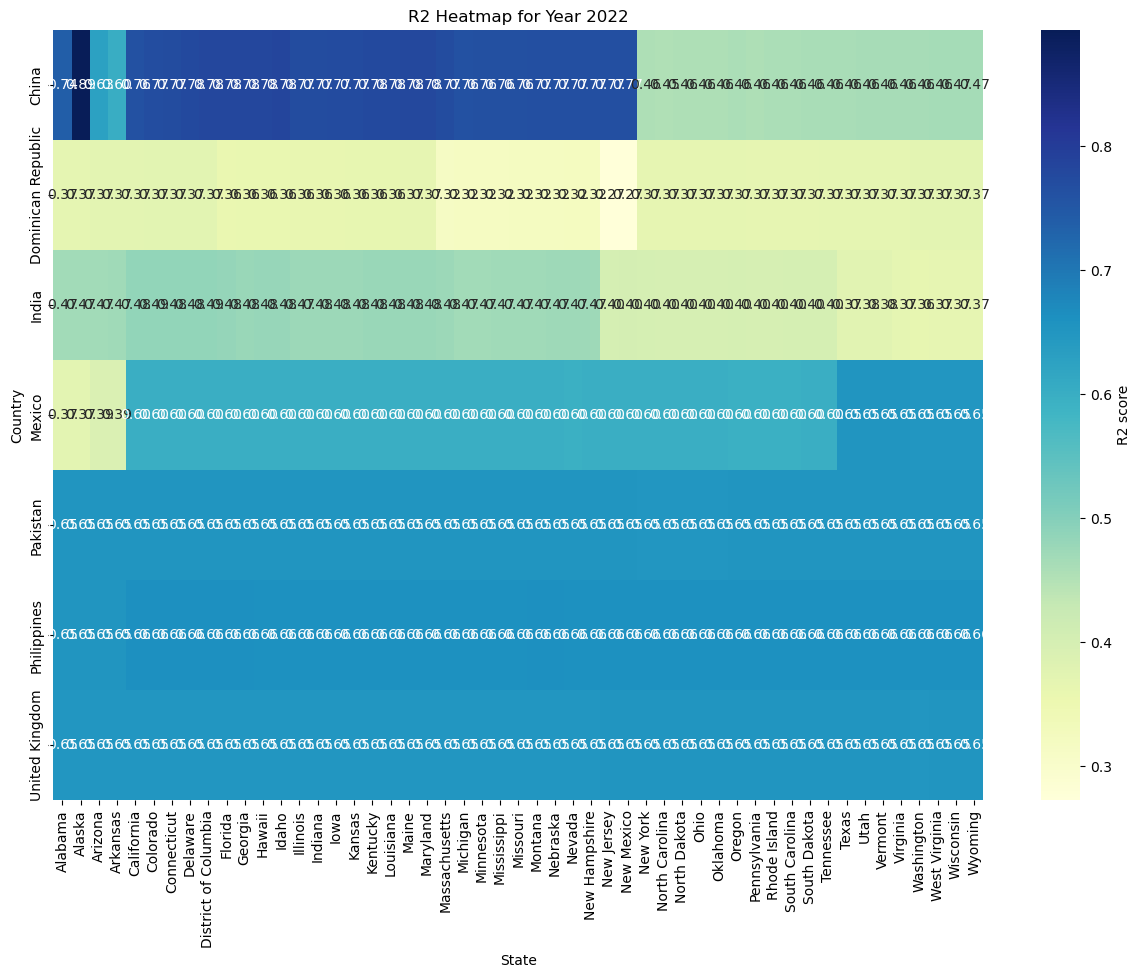

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the data for the year 2022
heatmap_df_2022 = df_predictions[df_predictions['Year'] == 2022]
print(heatmap_df_2022.describe())

# Pivot the filtered DataFrame to have countries as rows, states as columns, and predicted immigration as values
heatmap_df_2022 = heatmap_df_2022.pivot(index='Country', columns='State', values='R2')

# Plot the heatmap for 2022
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_df_2022, annot=True, cmap='YlGnBu', fmt=".2f", cbar_kws={'label': 'R2 score'})
plt.title('R2 Heatmap for Year 2022')
plt.show()
